In [5]:
import numpy as np 
from tqdm import tqdm
import cv2 
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import glob
import nibabel as nib
import re

import pydicom as dicom
import os
import numpy as np
import matplotlib.pyplot as plt
from dcmrtstruct2nii import dcmrtstruct2nii, list_rt_structs
import glob
import nibabel as nib

from scipy import ndimage
import csv

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

init_notebook_mode(connected=True)
RANDOM_SEED = 123

# Apply N4-Bias-Correction for Contrast Uniformality

In [52]:


def n4_correction(im_input, output_im):
    command1 = ("C:/data/radiomics/release/N4BiasFieldCorrection.exe" ' -i ' + im_input + ' -o ' + output_im)
    os.system(command1)
    print(command1)

### This script is used to convert dicom series together with contour RT-structure to nifty format;
# then n4-correction (.exe wrote by Eric Carver) for better contrast;
# then radiomics feature extraction using "pyradiomics" (because batch mode well supported with this library)
# in addition, it also generates quality control pictures for the purpose of peer review
# in order for this script to work, please create a local folder("C:/data/radiomics/") and export T2W + single-contour RTstruct from MIM into this folder
# Author: Weiwei Zong & Eric Carver
# 05/11/2020
#########################

for file in glob.glob("C:/data/radiomics/prostatex/*/ProstateX-0054*ADC*/"): ##
    ### first read from folder of T2W dicom series exported from MIM
    ### TIP: in order for "dcmrtstruct2nii" to work, only export single-contour RT-structure!!!
    img_path = file
    ### the folder for contours are named in a different way than images
    ### this part is to modify image folder to get contour folder
#     contour_folder = img_path
    img_path = img_path.replace('\\', '/')
#     contour_folder = contour_folder.replace('_MR_', '_RTst_')
#     contour_folder = contour_folder.replace('_t2.tse.tra_n19__00000', '_._n1__00000')

    temp = img_path.split('/')
    pt_id = temp[-2][0:14] # prostatex 14
    print(temp)
    rt_prefix = pt_id + '_' + pt_id + '_' + 'RTst'
    print(rt_prefix)
    contour_folder = [filename for filename in os.listdir(temp[0]+'/'+temp[1]+'/'+temp[2]+'/'+temp[3]+'/'+temp[4]) if filename.startswith(rt_prefix)]
    contour_folder = temp[0]+'/'+temp[1]+'/'+temp[2]+'/'+temp[3]+'/'+temp[4]+'/'+contour_folder[0]

    ##
    ### replace image folder name with contour folder name ###
    ### python string not immutable so use 'list' here
    # temp1 = list(contour_folder)
    # temp1[-22:] = 'Prostate-only_n1__00000'
    # # contour_folder1 = contour_folder
    # contour_folder1 = ''.join(temp1)
    # temp1 = list(contour_folder)
    # temp1[-22:] = 'l2-T2-only_n1__00000'
    # contour_folder2 = contour_folder
    # contour_folder2 = ''.join(temp1)
    # temp1 = list(contour_folder)
    # temp1[-22:] = 'l3-T2-only_n1__00000'
    # contour_folder3 = contour_folder
    # contour_folder3 = ''.join(temp1)

    print(contour_folder)
    ### make folder to store generated nifty files (C:/data/radiomics/nii_output/)
    ### images and contours in nifty format will be stored under folders named after each patient ID
    output_folder = os.path.join('C:/data/radiomics/prostatex-nii/', pt_id)
    os.mkdir(output_folder)

#     os.chdir(output_folder)
    ### loop for every patient
    for file1 in os.listdir(contour_folder):
        if file1.endswith(".dcm"):
            ### dicom to nifty
            ### calling python library "dcmrtstruct2nii"
            contour_file = os.path.join(contour_folder, file1)
            print(contour_file)
            dcmrtstruct2nii(
                contour_file,
                img_path,
                output_folder)
            os.chdir(output_folder)
            print(output_folder)
            ### n4 correction for better contrast
            ### calling .exe "n4_correction" wrote by Eric Carver
            ### the generated nifty files for both images and contour will be stored in the output folder
            n4_correction('image.nii.gz', 'ADC_biasCorrect.nii.gz')

['C:', 'data', 'radiomics', 'prostatex', '2011-11__Studies', 'ProstateX-0054_ProstateX-0054_MR_2011-11-23_091144_MR.prostaat.kanker.detectie.mc.MCAPRODET_(reoriented)Res.Reg.ADC_n21__00000', '']
ProstateX-0054_ProstateX-0054_RTst
C:/data/radiomics/prostatex/2011-11__Studies/ProstateX-0054_ProstateX-0054_RTst_2011-11-23_091144_MR.prostaat.kanker.detectie.mc.MCAPRODET_prostate-only_n1__00000


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/data/radiomics/prostatex-nii/ProstateX-0054'

## load one slice to visualize the after N4-Bias-Correction effect

float32


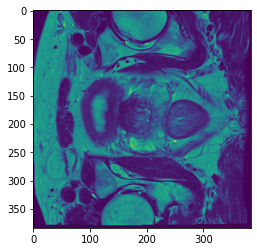

In [52]:
# Read the t2 image 
struct = nib.load('C:/data/radiomics/prostatex-nii/ProstateX-0000/biasCorrect.nii.gz')

# Get a plain NumPy array, without all the metadata
t2 = np.array(struct.dataobj)
# img = img.reshape((38, 512, 512))
t2.shape

plt.imshow(t2[:,:,10])

print(t2.d type)

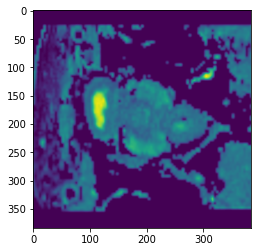

In [6]:
# Read the ADC image 
struct = nib.load('C:/data/radiomics/prostatex-nii/ProstateX-0000/ADC_biasCorrect.nii.gz')

# Get a plain NumPy array, without all the metadata
adc = np.array(struct.dataobj)
# img = img.reshape((38, 512, 512))
# adc.shape
np.amax(adc)

plt.imshow(adc[:,:,10])

uint8


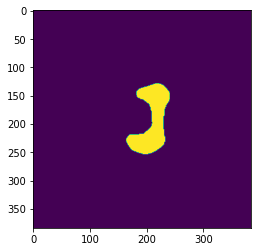

In [51]:
# Read the peripheral zone RT-struct
struct = nib.load('C:/data/radiomics/prostatex-nii/ProstateX-0000/mask_PZ-SchaffE.nii.gz')

# Get a plain NumPy array, without all the metadata
ps = np.array(struct.dataobj)
# img = img.reshape((38, 512, 512))
ps.shape
np.amax(ps)

plt.imshow(ps[:,:,10])

print(ps.dtype)

## Dilate the binary mask with 10x10 kernel

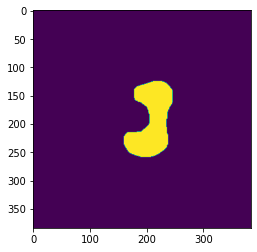

In [47]:
kernel = np.ones((10,10),np.uint8)
dilation = cv2.dilate(ps[:,:,10],kernel,iterations = 1)

dilation.shape
np.amax(dilation) #255

plt.imshow(dilation)

# Pre-processing
## Crop the PZ out of 1 slice

(164, 226)
(240, 157)


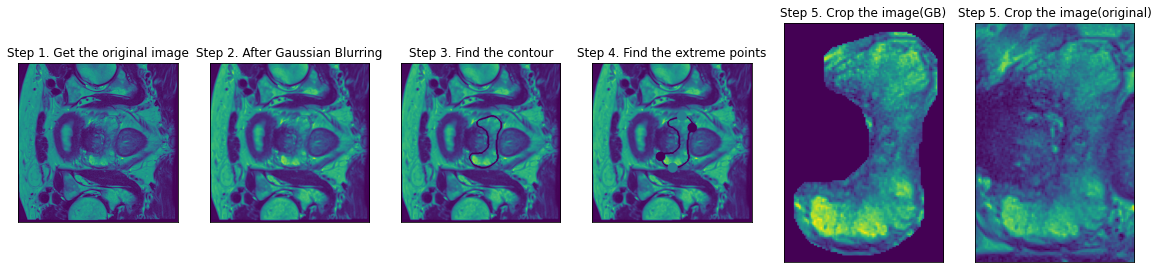

In [48]:
import cv2

gray = t2[:,:,10]/t2[:,:,10].max() * 255 # normalize t2 to [0, 255]
gb = cv2.GaussianBlur(t2[:,:,10], (5, 5), 0)
thresh = ps[:,:,10]
dilation_uni = dilation / 255 # normalize PZ mask to [0, 1]
crop = gray * dilation_uni # crop the PZ out
# print(gray.max())

# find contours in mask
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

print(extLeft)
print(extRight)

# add contour on the image
img_cnt = cv2.drawContours(gb.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 12, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 12, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 12, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 12, (255, 255, 0), -1)

# crop
ADD_PIXELS = 10
new_img = crop[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
new_img_test = gray[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# plot
plt.figure(figsize=(20,6))
plt.subplot(161)
plt.imshow(t2[:,:,10])
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(162)
plt.imshow(gb)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. After Gaussian Blurring')
plt.subplot(163)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the contour')
plt.subplot(164)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Find the extreme points')
plt.subplot(165)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 5. Crop the image(GB)')
plt.subplot(166)
plt.imshow(new_img_test)
plt.xticks([])
plt.yticks([])
plt.title('Step 5. Crop the image(original)')
plt.show()

# Pre-processing
## -- Display 1 Patient with the sequence

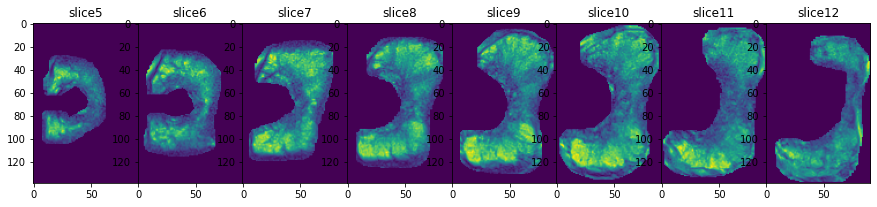

In [116]:
temp = 1
kernel = np.ones((10,10),np.uint8)
img_size = 150

# plot the croped prostate mri            
fig, axs = plt.subplots(1,8, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for slice_id in range(ps.shape[2]):
    if np.any(ps[:, :, slice_id]):
        thresh = ps[:,:,slice_id]
        
        dilation = cv2.dilate(thresh,kernel,iterations = 1)


# find contours in mask
        cnts = cv2.findContours(dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

# find the extreme points on 1 slice
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        
        if temp:
            temp = 0
            final_extLeft = extLeft
            final_extRight = extRight
            final_extTop = extTop
            final_extBot = extBot
            
# find the extreme points of all the slices            
        if final_extLeft[0] > extLeft[0]: final_extLeft = extLeft 
        if final_extRight[0] < extRight[0]: final_extRight = extRight 
        if final_extTop[1] > extTop[1]: final_extTop = extTop 
        if final_extBot[1] < extBot[1]: final_extBot = extBot 


# crop
temp = 0
new_img = np.zeros((139, 91, 8))
for slice_id in range(ps.shape[2]):
    if np.any(ps[:, :, slice_id]):
        thresh = ps[:,:,slice_id]
        
        dilation = cv2.dilate(thresh,kernel,iterations = 1)
        
        dilation_uni = dilation / 255
        crop = t2[:, :, slice_id] * dilation_uni
        
        ADD_PIXELS = 2
        new_img[:,:,temp] = crop[final_extTop[1]-ADD_PIXELS:final_extBot[1]+ADD_PIXELS, final_extLeft[0]-ADD_PIXELS:final_extRight[0]+ADD_PIXELS].copy()

        
        
        
        axs[slice_id-5].imshow(new_img[:,:,temp])
        axs[slice_id-5].set_title('slice' + str(slice_id))
        
        temp += 1

plt.show()

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.
x = np.arange(0, 20, 0.1)
ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(x - 5 + i)
    ax.set_xlabel(label)
    return line, ax

if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
    anim.save('C:/data/radiomics/line.gif', dpi=80, writer='imagemagick')
    
        # plt.show() will just loop the animation forever.
    plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


fig size: 100.0 DPI, size in inches [6.4 4.8]
timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9


<Figure size 640x480 with 1 Axes>

# Pre-processing
## Create Animation of Cropped PZ for Quality Control Purpose

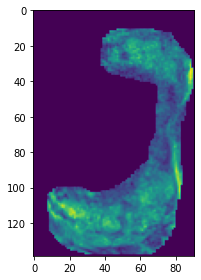

In [117]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# # Query the figure's on-screen size and DPI. Note that when saving the figure to
# # a file, we need to provide a DPI for that separately.
# print('fig size: {0} DPI, size in inches {1}'.format(
#     fig.get_dpi(), fig.get_size_inches()))

# # Plot a scatter that persists (isn't redrawn) and the initial line.
# x = np.arange(0, 20, 0.1)
# ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
# line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
#     label = 'timestep {0}'.format(i)
#     print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    ax.imshow(new_img[:,:,i]) # cropped PZ stored in 'new_img'
    return ax

if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, 8), interval=300)
    anim.save('C:/data/radiomics/'+pt_id+'-pz.gif', dpi=80, writer='imagemagick')
    
        # plt.show() will just loop the animation forever.
    plt.show()

In [80]:
for pt_folder in glob.glob('C:/data/radiomics/prostatex-nii/*'):
        temp = pt_folder.split('\\')
        pt_id = temp[-1] # prostatex 14
        print(pt_id)
    

ProstateX-0000
ProstateX-0001
ProstateX-0002
ProstateX-0004
ProstateX-0005
ProstateX-0007
ProstateX-0009
ProstateX-0012
ProstateX-0014
ProstateX-0015
ProstateX-0016
ProstateX-0018
ProstateX-0019
ProstateX-0020
ProstateX-0026
ProstateX-0028
ProstateX-0029
ProstateX-0031
ProstateX-0033
ProstateX-0035
ProstateX-0037
ProstateX-0039
ProstateX-0044
ProstateX-0046
ProstateX-0053
ProstateX-0054
ProstateX-0055
ProstateX-0056
ProstateX-0059
ProstateX-0060
ProstateX-0065
ProstateX-0066
ProstateX-0067
ProstateX-0069
ProstateX-0070
ProstateX-0071
ProstateX-0072
ProstateX-0076
ProstateX-0077
ProstateX-0078
ProstateX-0080
ProstateX-0082
ProstateX-0083
ProstateX-0084
ProstateX-0089
ProstateX-0090
ProstateX-0092
ProstateX-0094
ProstateX-0095
ProstateX-0096
ProstateX-0097
ProstateX-0099
ProstateX-0101
ProstateX-0102
ProstateX-0103
ProstateX-0104
ProstateX-0105
ProstateX-0106
ProstateX-0107
ProstateX-0110
ProstateX-0111
ProstateX-0112
ProstateX-0114
ProstateX-0115
ProstateX-0116
ProstateX-0117
ProstateX-

# Pre-processing
## Batch Mode cropping PZ, marginal space 10 pixels

In [134]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def crop_imgs_25D(data_path, add_pixels_value=10, img_size=(150, 150)):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    
    # path = "C:\\data\\radiomics\\prostate_nii_output\\ProstateX-0000\\"
    set_new = np.empty([150, 150, 3, 1])
    
    # read pt id
    gleason_df = pd.read_csv("C:/data/radiomics/Gleason-info-cg-2.csv", na_values = ['no info', '.'])
    pz = gleason_df[(gleason_df['zone'] == "PZL") | (gleason_df['zone'] == "PZU") | (gleason_df['zone'] == "PZC") | (gleason_df['zone'] == "PZ") | (gleason_df['zone'] == "NL")] 
#    cg = gleason_df[(gleason_df['zone'] == "CG")  | (gleason_df['zone'] == "NL")]
    kernel = np.ones((10,10),np.uint8)
    print(len(pz))
    
    for pt_idx in range(len(pz)): ## pz or cg
        
        pt_id = pz['ProxID'][pz.index[pt_idx]] ## pz or cg
        print(pt_id)
        pt_folder = "C:/data/radiomics/prostatex-nii/" + pt_id


        # read mask into numpy
#         # CG   
#         for f in os.listdir(pt_folder):
#             if re.match('mask_A', f): # AFS file matching
#                 mask_path = pt_folder + "/" + f
#                 mask1 = nib.load(mask_path)
#                 mask1 = np.array(mask1.dataobj)
       
#         for f in os.listdir(pt_folder):
#             if re.match('mask_T', f): # TZ file matching
#                 mask_path = pt_folder + "/" + f
#                 mask2 = nib.load(mask_path)
#                 mask2 = np.array(mask2.dataobj)
                   
#         mask = mask1 + mask2
#         central_index = int(pz['central_slice'][pz.index[pt_idx]])
#         print(central_index)
        
        
        
        # PZ           
        for f in os.listdir(pt_folder):
            if re.match('mask_P', f): # pz file matching
                mask_path = pt_folder + "/" + f
                mask = nib.load(mask_path)
                mask = np.array(mask.dataobj)

        central_index = int(pz['central_slice'][pz.index[pt_idx]])
        print(central_index)
##
# crop only 2.5D
        mask = mask[:,:,(central_index - 1):(central_index + 2)]
        print(mask.shape)

        
 # read image into numpy   

        img = nib.load(pt_folder + "/ADC_biasCorrect.nii.gz") ##
        img = np.array(img.dataobj)
        img = img[:,:,(central_index - 1):(central_index + 2)]
        
#         print(mask.shape)
        temp = 1
        for slice_id in range(mask.shape[2]):
            if np.any(mask[:, :, slice_id]):
                thresh = mask[:,:,slice_id]

# find contours in mask
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
                c = max(cnts, key=cv2.contourArea)

# find the extreme points on 1 slice
                extLeft = tuple(c[c[:, :, 0].argmin()][0])
                extRight = tuple(c[c[:, :, 0].argmax()][0])
                extTop = tuple(c[c[:, :, 1].argmin()][0])
                extBot = tuple(c[c[:, :, 1].argmax()][0])
        
                if temp:
                    temp = 0
                    final_extLeft = extLeft
                    final_extRight = extRight
                    final_extTop = extTop
                    final_extBot = extBot
            
# find the extreme points of all the slices            
                if final_extLeft[0] > extLeft[0]: final_extLeft = extLeft 
                if final_extRight[0] < extRight[0]: final_extRight = extRight 
                if final_extTop[1] > extTop[1]: final_extTop = extTop 
                if final_extBot[1] < extBot[1]: final_extBot = extBot 
                    
# crop only prostate

        new_img = np.zeros((150, 150, 3))
        slice_idd = 0
        for slice_id in range(mask.shape[2]):
            if np.any(mask[:, :, slice_id]):
#                 gb = cv2.GaussianBlur(img[:,:,slice_id], (5, 5), 0)
                thresh = mask[:,:,slice_id]
                dilation = cv2.dilate(thresh,kernel,iterations = 1)
                dilation_uni = dilation / 255
                crop = img[:, :, slice_id] * dilation_uni 
                

# crop
                ADD_PIXELS = 5
                gb_temp = crop[final_extTop[1]-ADD_PIXELS:final_extBot[1]+ADD_PIXELS, final_extLeft[0]-ADD_PIXELS:final_extRight[0]+ADD_PIXELS].copy()
                gb_temp = cv2.resize(
                    gb_temp,
                    dsize=img_size,
                    interpolation=cv2.INTER_CUBIC
                )
                
                new_img[:,:,slice_idd] = gb_temp
                slice_idd += 1 
             
                
                # QA
        
        fig, ax = plt.subplots()
        fig.set_tight_layout(True)
        def update(i):
            ax.imshow(new_img[:,:,i])
            return ax
        anim = FuncAnimation(fig, update, frames=np.arange(0, new_img.shape[-1]), interval=500)
        anim.save('C:/data/radiomics/QA/'+pt_id+'-ADC-25D-pz.gif', dpi=80, writer='imagemagick')
        plt.close(fig)       
        
        new_img = np.expand_dims(new_img, axis=-1)       
        set_new = np.append(set_new, new_img, axis = -1)     
 

    print(set_new.shape)
    return np.array(set_new[:,:,:,1:])

In [119]:
# apply this for each set
X_train_t2_cg = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*")

MovieWriter imagemagick unavailable; using Pillow instead.


98
ProstateX-0001
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0004
7
(384, 384, 3)
ProstateX-0007
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0009
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0012
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0014
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0015
7
(384, 384, 3)
ProstateX-0016
3
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0018
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0020
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0026
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0029
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0035
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0037
8
(384, 384, 3)
ProstateX-0039
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0044
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0055
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0059
9
(384, 384, 3)
ProstateX-0060
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0065
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0070
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0071
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0072
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0078
7
(384, 384, 3)
ProstateX-0080
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0082
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(384, 384, 3)
ProstateX-0089
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0090
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0092
7
(384, 384, 3)
ProstateX-0094
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0096
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0097
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0101
3
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0102
4
(384, 384, 3)
ProstateX-0104
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0105
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0106
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(320, 320, 3)
ProstateX-0110
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0111
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0112
9
(384, 384, 3)
ProstateX-0114
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0115
12
(384, 384, 3)
ProstateX-0118
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0119
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0120
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0121
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0122
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0125
10
(384, 384, 3)
ProstateX-0126
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0130
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0131
11
(384, 384, 3)
ProstateX-0133
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0134
9
(384, 384, 3)
ProstateX-0136
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0139
6
(384, 384, 3)
ProstateX-0142
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0143
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0144
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0145
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0146
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0148
3
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0150
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0152
9
(384, 384, 3)
ProstateX-0153
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0154
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0156
9
(384, 384, 3)
ProstateX-0161
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0162
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0164
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0165
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0168
6
(384, 384, 3)
ProstateX-0169
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0170
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0172
3
(384, 384, 3)
ProstateX-0173
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0174
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0177
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0179
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0180
9
(384, 384, 3)
ProstateX-0181
9
(640, 640, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0186
6
(384, 384, 3)
ProstateX-0187
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0188
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0191
7
(384, 384, 3)
ProstateX-0194
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0195
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0197
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0198
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0199
10
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0201
16
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0202
10
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0203
7
(320, 320, 3)
(150, 150, 3, 99)


In [122]:
# apply this for each set
X_train_adc_cg = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*")

MovieWriter imagemagick unavailable; using Pillow instead.


98
ProstateX-0001
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0004
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0007
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0009
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0012
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0014
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0015
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0016
3
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0018
5
(384, 384, 3)
ProstateX-0020
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0026
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0029
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0035
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0037
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0039
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0044
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0055
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0059
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0060
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0065
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0070
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0071
12
(384, 384, 3)
ProstateX-0072
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0078
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0080
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0082
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0089
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0090
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0092
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0094
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0096
9
(384, 384, 3)
ProstateX-0097
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0101
3
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0102
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0104
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0105
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0106
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0110
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0111
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0112
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0114
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0115
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0118
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0119
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0120
9
(384, 384, 3)
ProstateX-0121
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0122
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0125
10
(384, 384, 3)
ProstateX-0126
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0130
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0131
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0133
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0134
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0136
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0139
6
(384, 384, 3)
ProstateX-0142
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0143
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0144
9
(384, 384, 3)
ProstateX-0145
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0146
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0148
3
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0150
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0152
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0153
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0154
9
(384, 384, 3)
ProstateX-0156
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0161
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0162
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0164
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0165
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0168
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0169
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0170
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0172
3
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0173
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0174
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0177
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0179
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0180
9
(384, 384, 3)
ProstateX-0181
9
(640, 640, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0186
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0187
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0188
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0191
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0194
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0195
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0197
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0198
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0199
10
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0201
16
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0202
10
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0203
7
(320, 320, 3)
(150, 150, 3, 99)


In [135]:
# apply this for each set
X_train_adc_pz = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*")

MovieWriter imagemagick unavailable; using Pillow instead.


71
ProstateX-0000
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0002
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0005
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0007
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0009
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0012
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0019
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0020
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0028
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0029
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0031
16
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0039
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0044
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0046
11
(384, 384, 3)
ProstateX-0053
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0059
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0060
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0065
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0067
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0069
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0070
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0072
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0076
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0077
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0080
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0084
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0089
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0090
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0095
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0096
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0099
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0103
14
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0112
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0116
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0117
14
(384, 384, 3)
ProstateX-0120
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0121
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0123
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0124
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0127
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0128
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0129
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0130
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0134
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0139
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0144
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0146
9
(384, 384, 3)
ProstateX-0154
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0156
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0161
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0170
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0173
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0177
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0180
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0182
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0183
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0184
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0188
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0190
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0192
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0193
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0195
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0196
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0200
11
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0203
12
(320, 320, 3)
(150, 150, 3, 72)


In [133]:
# apply this for each set
X_train_t2_pz = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*")

MovieWriter imagemagick unavailable; using Pillow instead.


71
ProstateX-0000
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0002
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0005
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0007
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0009
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0012
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0019
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0020
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0028
6
(384, 384, 3)
ProstateX-0029
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0031
16
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0039
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0044
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0046
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0053
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(384, 384, 3)
ProstateX-0059
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0060
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0065
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0067
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0069
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0070
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0072
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0076
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0077
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0080
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0084
4
(384, 384, 3)
ProstateX-0089
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0090
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0095
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0096
9
(384, 384, 3)
ProstateX-0099
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0103
14
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0112
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0116
9
(384, 384, 3)
ProstateX-0117
14
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0120
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0121
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0123
7
(384, 384, 3)
ProstateX-0124
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0127
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0128
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0129
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0130
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0134
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0139
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0144
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0146
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0154
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0156
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0161
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0170
9
(384, 384, 3)
ProstateX-0173
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0177
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0180
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0182
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0183
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0184
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0188
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0190
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0192
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0193
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0195
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0196
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0200
11
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0203
12
(320, 320, 3)
(150, 150, 3, 72)


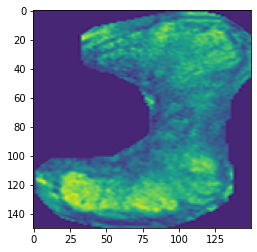

In [66]:
from matplotlib import pyplot as plt
plt.imshow(X_train_t2_pz[:,:,2,0])
plt.show()

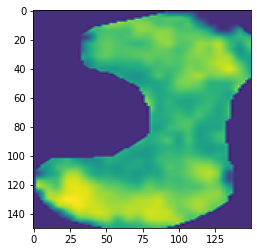

In [67]:
from matplotlib import pyplot as plt
plt.imshow(X_train_adc_pz[:,:,2,0])
plt.show()

In [2]:
import pandas as pd
gleason_df = pd.read_csv("C:/data/radiomics/Gleason-info-cg-2.csv", na_values = ['no info', '.'])
print(gleason_df.head(10))
print(len(gleason_df.index))

           ProxID  fid                                                pos  \
0  ProstateX-0000  1.0                            25.7457 31.8707 -38.511   
1  ProstateX-0001  1.0  -40.5367071921656 29.320722668457 -16.70766907...   
2  ProstateX-0002  1.0                          -27.0102 41.5467 -26.0469   
3  ProstateX-0002  2.0                            -2.058 38.6752 -34.6104   
4  ProstateX-0004  1.0                           -7.69665 3.64226 23.1659   
5  ProstateX-0005  1.0                           -38.6276 42.2781 21.4084   
6  ProstateX-0007  NaN                                                NaN   
7  ProstateX-0009  NaN                                                NaN   
8  ProstateX-0012  NaN                                                NaN   
9  ProstateX-0014  1.0                           -23.0672 31.7673 3.02353   

  zone  ggg  diganosis  central_slice Unnamed: 7 Unnamed: 8  
0  PZU    3          3              9        NaN        NaN  
1   CG    1          2      

In [124]:
cg = gleason_df[(gleason_df['zone'] == "CG") | (gleason_df['zone'] == "NL")]
# cg.index[1]
cg.head(5)
# cg.duplicated(subset=['ProxID'])

,ProxID,fid,pos,zone,ggg,diganosis,central_slice,Unnamed: 7,Unnamed: 8
1,ProstateX-0001,1.0,-40.5367071921656 29.320722668457 -16.70766907...,CG,1,2.0,9.0,NaN,NaN
3,ProstateX-0004,1.0,-7.69665 3.64226 23.1659,CG,1,2.0,7.0,NaN,NaN
5,ProstateX-0007,NaN,NaN,NL,0,1.0,9.0,NaN,NaN
6,ProstateX-0009,NaN,NaN,NL,0,1.0,9.0,NaN,NaN
7,ProstateX-0012,NaN,NaN,NL,0,1.0,9.0,NaN,NaN


In [88]:
pz = gleason_df[(gleason_df['zone'] == "PZL") | (gleason_df['zone'] == "PZU") | (gleason_df['zone'] == "PZC") | (gleason_df['zone'] == "PZ")] 
pz.head(5)

,ProxID,fid,pos,zone,ggg,diganosis,central_slice,Unnamed: 7,Unnamed: 8
0,ProstateX-0000,1.0,25.7457 31.8707 -38.511,PZU,3,3.0,9.0,NaN,NaN
2,ProstateX-0002,1.0,-27.0102 41.5467 -26.0469,PZU,2,3.0,12.0,NaN,NaN
4,ProstateX-0005,0.0,-14.5174331665039 49.4428329467773 20.78152465...,PZL,2,3.0,9.0,NaN,NaN
12,ProstateX-0019,1.0,-4.21012 42.1916 -40.6457,PZU,2,3.0,9.0,NaN,NaN
15,ProstateX-0028,1.0,32.6256 39.4066 -7.95307,PZL,2,3.0,6.0,NaN,NaN


In [89]:
cg['ggg'] = cg['ggg'].astype(float)
pz['ggg'] = pz['ggg'].astype(float)

C:\Users\wzong1\Anaconda3\envs\gleason36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\wzong1\Anaconda3\envs\gleason36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
pz['ggg'].dtype

dtype('float64')

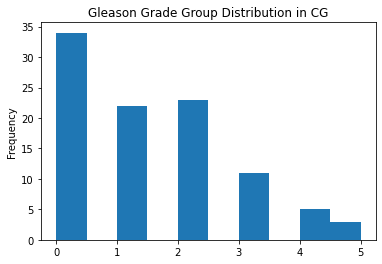

In [74]:
cg['ggg'].plot(kind='hist', title='Gleason Grade Group Distribution in CG');

In [95]:
pz = gleason_df[(gleason_df['zone'] == "PZL") | (gleason_df['zone'] == "PZU") | (gleason_df['zone'] == "PZ") | (gleason_df['zone'] == "PZC") | (gleason_df['zone'] == "NL")]
# cg.index[1]
pz.head(5)
# cg.duplicated(subset=['ProxID'])

,ProxID,fid,pos,zone,ggg,diganosis,central_slice,Unnamed: 7,Unnamed: 8
0,ProstateX-0000,1.0,25.7457 31.8707 -38.511,PZU,3,3.0,9.0,NaN,NaN
2,ProstateX-0002,1.0,-27.0102 41.5467 -26.0469,PZU,2,3.0,12.0,NaN,NaN
4,ProstateX-0005,0.0,-14.5174331665039 49.4428329467773 20.78152465...,PZL,2,3.0,9.0,NaN,NaN
5,ProstateX-0007,NaN,NaN,NL,0,1.0,9.0,NaN,NaN
6,ProstateX-0009,NaN,NaN,NL,0,1.0,9.0,NaN,NaN


C:\Users\wzong1\Anaconda3\envs\gleason36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



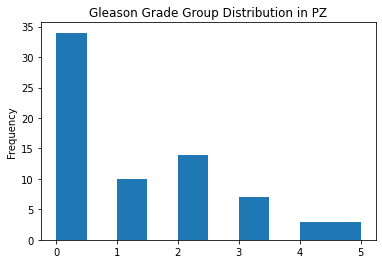

In [77]:
pz['ggg'] = pz['ggg'].astype(float)
pz['ggg'].dtype
pz['ggg'].plot(kind='hist', title='Gleason Grade Group Distribution in PZ');

In [125]:
len(cg)
# 69 CG cases

98

In [126]:
pt_list = cg['ProxID']
label_list = cg['ggg']
# print(pt_list.index)
for row_id in pt_list.index:
    pt_id = pt_list[row_id]
    data_path = 'C:/data/radiomics/prostatex-nii/' + pt_id + '/biasCorrect.nii.gz'
    label = label_list[row_id]
    print(data_path)

C:/data/radiomics/prostatex-nii/ProstateX-0001/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0004/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0007/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0009/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0012/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0014/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0015/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0016/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0018/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0020/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0026/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0029/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0033/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0035/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0037/biasCorrect.nii.gz
C:/data/ra

In [127]:
print(len(np.asarray(label_list)))

98


# Pre-processing
## save numpy

In [128]:
np.savez('C:/data/radiomics/train_cg_25D_98pt.npz', t2=X_train_t2_cg, adc=X_train_adc_cg, label = label_list.astype(int))

In [113]:
np.savez('C:/data/radiomics/train_pz_25D_71pt.npz', t2=X_train_t2_pz, adc=X_train_adc_pz, label = label_list.astype(int))

# Review Input before Training

In [137]:
# Load and Check data size
data = np.load('C:/data/radiomics/train_pz_25D_71pt.npz') # 
print (data['t2'].shape)
print (data['adc'].shape)
print (data['label'].shape)

(150, 150, 3, 71)
(150, 150, 3, 71)
(71,)


3


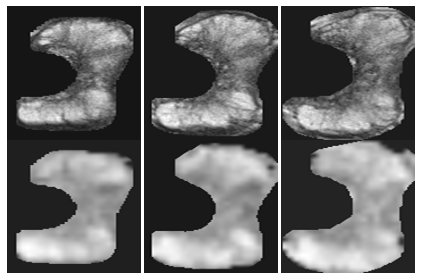

In [141]:
# Display images to double check
t2 = data['t2']
adc = data['adc']
label = data['label']
print(label[0])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,0], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,0], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,0], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,0], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,0], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,0], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

0


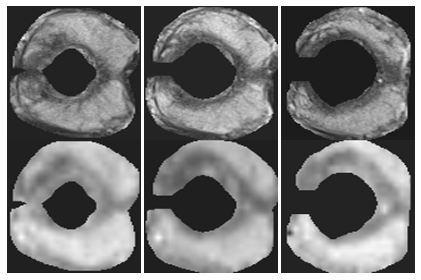

In [142]:
# Display another random example
t2 = data['t2']
adc = data['adc']
label = data['label']
print(label[5])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,5], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,5], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,5], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,5], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,5], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,5], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

5


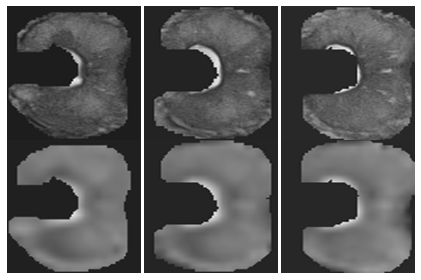

In [140]:
t2 = data['t2']
adc = data['adc']
label = data['label']
print(label[-2])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,-2], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,-2], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,-2], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,-2], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,-2], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,-2], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
# Load and review CG
data = np.load('C:/data/radiomics/train_cg_25D_97pt.npz')
print (data['t2'].shape)
print (data['adc'].shape)
print (data['label'].shape)

(150, 150, 3, 97)
(150, 150, 3, 97)
(97,)


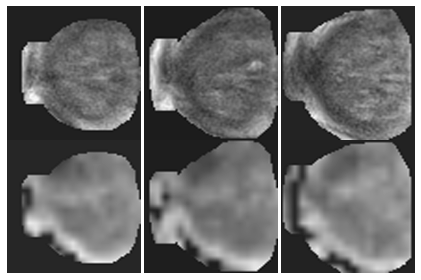

In [130]:
t2 = data['t2']
adc = data['adc']
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,0], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,0], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,0], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,0], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,0], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,0], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

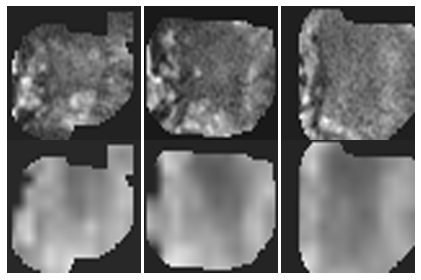

In [131]:
t2 = data['t2']
adc = data['adc']
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,5], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,5], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,5], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,5], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,5], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,5], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

In [9]:
np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1).shape

(97, 150, 150, 3)

In [10]:
np.amax(np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1))

1163.2572089040127

# Training PZ
## With Single-modal Input: T2

In [162]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint

def save_model(self, trial_id, model, step=0):
    epoch = step
    self._checkpoint_model(model, trial_id, epoch)
    # TODO: save the top epoch checkpoints instead of last ones.
    epoch_to_delete = epoch - self._save_n_checkpoints
    best_epoch = self.oracle.get_trial(trial_id).best_step
    # if epoch > self._save_n_checkpoints and epoch_to_delete != best_epoch:
    #    self._delete_checkpoint(
    #        trial_id, epoch_to_delete)

input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="vanilla",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=True,
)(input_node)
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
#     preprocessors=None,
    project_name="gleason-no-augmentation",
    max_trials=20,
    directory="C:/data/radiomics",
    
    tuner="greedy",
    seed=None,)
# # Save the checkpoint in the /output folder
# filepath = "C:/data/autotest/gleason-no-augmentation"

# # Keep only a single checkpoint, the best over test accuracy.
# checkpoint = ModelCheckpoint(filepath,
#                             monitor='loss',
#                             verbose=1,
#                             save_best_only=True,
#                             mode='min')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# fit
reg.fit(np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1), data['label'], epochs=None, callbacks=[callback])

# Export as a Keras Model.
model = reg.export_model()

# print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/PZ/t2-only", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/PZ/t2-only/model_autokeras.h5")

Trial 10 Complete [00h 01m 08s]
val_loss: 1.5076179504394531

Best val_loss So Far: 1.5076179504394531
Total elapsed time: 00h 03m 51s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
2/2 [==============================] - 0s 119ms/step - loss: 13.2176 - mean_squared_error: 13.2176
Epoch 2/10
2/2 [==============================] - 0s 35ms/step - loss: 5.8572 - mean_squared_error: 5.8572
Epoch 3/10
2/2 [==============================] - 0s 35ms/step - loss: 9.4342 - mean_squared_error: 9.4342
Epoch 4/10
2/2 [==============================] - 0s 35ms/step - loss: 2.4576 - mean_squared_error: 2.4576
Epoch 5/10
2/2 [==============================] - 0s 36ms/step - loss: 12.8696 - mean_squared_error: 12.8696
Epoch 6/10
2/2 [==============================] - 0s 42ms/step - loss: 4.1880 - mean_squared_error: 4.1880
Epoch 7/10
2/2 [==============================] - 0s 36ms/step - loss: 1.9115 - mean_squared_error: 1.9115
Epoch 8/10
2/2 [==============================] - 0s 36ms/step - loss: 1.8468 - mean_squared_error: 1.8468
Epoch 9/10
2/2 [==============================] - 0s 35ms/step - loss: 1.5047 - mean_squared_error: 1.5047
Epoch 10/10
2/2 [===============

INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/PZ/t2-only\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/PZ/t2-only\assets


# PZ training
## With Single-Modal Input: ADC

In [166]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint

def save_model(self, trial_id, model, step=0):
    epoch = step
    self._checkpoint_model(model, trial_id, epoch)
    # TODO: save the top epoch checkpoints instead of last ones.
    epoch_to_delete = epoch - self._save_n_checkpoints
    best_epoch = self.oracle.get_trial(trial_id).best_step
    # if epoch > self._save_n_checkpoints and epoch_to_delete != best_epoch:
    #    self._delete_checkpoint(
    #        trial_id, epoch_to_delete)

input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="vanilla", # only searching for vanilla type of CNN
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=True,
)(input_node)
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
#     preprocessors=None,
    project_name="gleason-no-augmentation",
    max_trials=20,
    directory="C:/data/radiomics",
    
    tuner="greedy", # choosing "greedy" as the searching strategy
    seed=None,)
# # Save the checkpoint in the /output folder
# filepath = "C:/data/autotest/gleason-no-augmentation"

# # Keep only a single checkpoint, the best over test accuracy.
# checkpoint = ModelCheckpoint(filepath,
#                             monitor='loss',
#                             verbose=1,
#                             save_best_only=True,
#                             mode='min')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# fit
reg.fit(np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1), data['label'], epochs=None, callbacks=[callback])

# Export as a Keras Model.
model = reg.export_model()

# print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/PZ/adc-only", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/PZ/adc-only/model_autokeras.h5")

Trial 10 Complete [00h 00m 14s]
val_loss: 3.1501927375793457

Best val_loss So Far: 1.6916446685791016
Total elapsed time: 00h 04m 55s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/5
2/2 [==============================] - 0s 162ms/step - loss: 6.5929 - mean_squared_error: 6.5929
Epoch 2/5
2/2 [==============================] - 0s 98ms/step - loss: 3.3185 - mean_squared_error: 3.3185
Epoch 3/5
2/2 [==============================] - 0s 96ms/step - loss: 1.8681 - mean_squared_error: 1.8681
Epoch 4/5
2/2 [==============================] - 0s 110ms/step - loss: 6.6319 - mean_squared_error: 6.6319
Epoch 5/5
2/2 [==============================] - 0s 98ms/step - loss: 3.3692 - mean_squared_error: 3.3692
INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/PZ/adc-only\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/PZ/adc-only\assets


In [167]:
from tensorflow.keras.models import load_model

# output the predicted output for training and validation
model = reg.export_model() 

predicted_y = model.predict(np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1))
print(predicted_y)

# Display network structure
model.summary()

# Calculating the training error in rms
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(predicted_y, data['label'])
print("rms error is: " + str(rmse_val))

[[2.7558944]
 [2.8283744]
 [2.660993 ]
 [2.5637784]
 [2.6747975]
 [2.5686169]
 [2.450471 ]
 [2.6400442]
 [2.4998417]
 [2.5159075]
 [2.33001  ]
 [2.5604808]
 [2.4331017]
 [2.6286826]
 [2.5432916]
 [2.445597 ]
 [3.0627892]
 [2.427882 ]
 [2.5322235]
 [2.926022 ]
 [2.5875237]
 [2.4803884]
 [2.576984 ]
 [2.4041662]
 [2.7226555]
 [2.889969 ]
 [2.5142667]
 [2.6825585]
 [2.9053698]
 [2.6411428]
 [2.5332923]
 [2.7697554]
 [2.8253336]
 [2.4915967]
 [2.6510005]
 [2.4273138]
 [2.1961355]]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
__________________________________

# PZ training
## Parallel CNN - one CNN for T2 and one CNN for ADC

In [168]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint

input_node1 = ak.ImageInput()
output_node = ak.Normalization()(input_node1)
output_node = ak.ImageAugmentation()(output_node)
output_node1 = ak.ConvBlock()(output_node)
# output_node2 = ak.ResNetBlock(version='v2')(output_node)
# output_node1 = ak.Merge()([output_node1, output_node2])

input_node2 = ak.ImageInput()
output_node = ak.Normalization()(input_node2)
output_node = ak.ImageAugmentation()(output_node)
output_node2 = ak.ConvBlock()(output_node)
# output_node3 = ak.ResNetBlock(version='v2')(output_node)
# output_node2 = ak.Merge()([output_node2, output_node3])

output_node = ak.Merge()([output_node1, output_node2])
output_node2 = ak.RegressionHead()(output_node)

reg = ak.AutoModel(
    inputs=[input_node1, input_node2],
    outputs=output_node2,
    overwrite=True,
#     preprocessors=None,
    project_name="gleason-no-augmentation",
    max_trials=10,
    directory="C:/data/radiomics",
    
    tuner="greedy",
    seed=None,)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# fit
reg.fit([np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1), np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1)], data['label'], epochs=None, callbacks=[callback])

Trial 10 Complete [00h 01m 07s]
val_loss: 2.5814499855041504

Best val_loss So Far: 0.9635387659072876
Total elapsed time: 00h 11m 33s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/2
2/2 [==============================] - 0s 190ms/step - loss: 4.6913 - mean_squared_error: 4.6913
Epoch 2/2
2/2 [==============================] - 0s 157ms/step - loss: 41.0749 - mean_squared_error: 41.0749
INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


## save model

In [169]:
# Export as a Keras Model.
model = reg.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/PZ/t2-adc", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/PZ/t2-adc/model_autokeras.h5")

<class 'tensorflow.python.keras.engine.functional.Functional'>
INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/PZ/t2-adc\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/PZ/t2-adc\assets


In [170]:
from tensorflow.keras.models import load_model

# model = load_model("C:/data/autotest/gleason-no-augmentation", custom_objects=ak.CUSTOM_OBJECTS)
model = reg.export_model()

predicted_y = model.predict([np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1), np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1)])
print(predicted_y)
model.summary()
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(predicted_y, data['label'])
print("rms error is: " + str(rmse_val))

[[2.8571627 ]
 [2.9604373 ]
 [3.5421364 ]
 [2.9623296 ]
 [3.0200078 ]
 [3.3611288 ]
 [4.195274  ]
 [3.723425  ]
 [1.1754341 ]
 [1.8084043 ]
 [1.5794247 ]
 [1.4756886 ]
 [1.442271  ]
 [1.8353193 ]
 [2.5472658 ]
 [1.753402  ]
 [4.9232492 ]
 [2.349403  ]
 [1.9872354 ]
 [3.2320597 ]
 [2.0498362 ]
 [1.7849022 ]
 [2.2905982 ]
 [3.4180415 ]
 [2.255111  ]
 [3.297113  ]
 [1.2183604 ]
 [2.9537888 ]
 [4.859638  ]
 [2.0413015 ]
 [0.94650096]
 [2.6470518 ]
 [1.5276116 ]
 [1.7005596 ]
 [2.5348501 ]
 [2.860944  ]
 [1.0848606 ]]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0         

# CG Training

In [11]:
data = np.load('C:/data/radiomics/train_cg_25D_97pt.npz')
print (data['t2'].shape)
print (data['adc'].shape)
print (data['label'].shape)

(150, 150, 3, 97)
(150, 150, 3, 97)
(97,)


In [12]:
np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1).shape

(97, 150, 150, 3)

# CG Training
## T2-only

In [84]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint

def save_model(self, trial_id, model, step=0):
    epoch = step
    self._checkpoint_model(model, trial_id, epoch)
    # TODO: save the top epoch checkpoints instead of last ones.
    epoch_to_delete = epoch - self._save_n_checkpoints
    best_epoch = self.oracle.get_trial(trial_id).best_step
    # if epoch > self._save_n_checkpoints and epoch_to_delete != best_epoch:
    #    self._delete_checkpoint(
    #        trial_id, epoch_to_delete)

input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="vanilla",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=True,
)(input_node)
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
#     preprocessors=None,
    project_name="gleason-no-augmentation",
    max_trials=20,
    directory="C:/data/radiomics",
    
    tuner="bayesian",
    seed=None,)
# # Save the checkpoint in the /output folder
# filepath = "C:/data/autotest/gleason-no-augmentation"

# # Keep only a single checkpoint, the best over test accuracy.
# checkpoint = ModelCheckpoint(filepath,
#                             monitor='loss',
#                             verbose=1,
#                             save_best_only=True,
#                             mode='min')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# fit
reg.fit(np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1), data['label'], epochs=None, callbacks=[callback])

# Export as a Keras Model.
model = reg.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/CG/t2-only", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/CG/t2-only/model_autokeras.h5")

Trial 20 Complete [00h 00m 44s]
val_loss: 1.7183451652526855

Best val_loss So Far: 1.655120849609375
Total elapsed time: 00h 12m 41s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


2/2 [==============================] - 0s 237ms/step - loss: 4.8006 - mean_squared_error: 4.8006
INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


<class 'tensorflow.python.keras.engine.functional.Functional'>
INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/CG/t2-only\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/CG/t2-only\assets


In [96]:
from tensorflow.keras.models import load_model

model = load_model("C:/data/radiomics/saved_model/CG/adc-only/", custom_objects=ak.CUSTOM_OBJECTS)
# model = reg.export_model()

predicted_y = model.predict(np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1))
print(predicted_y)
model.summary()
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(predicted_y, data['label'])
print("rms error is: " + str(rmse_val))

[[1.7569542]
 [1.7192912]
 [1.2931145]
 [1.5314771]
 [2.8999805]
 [1.9942813]
 [2.965719 ]
 [1.7368611]
 [1.5752133]
 [1.7700095]
 [1.3530253]
 [1.6500436]
 [2.0278432]
 [1.8045615]
 [1.3529508]
 [1.5096294]
 [1.8903427]
 [1.8489732]
 [2.2829638]
 [1.4040072]
 [1.849637 ]
 [1.767637 ]
 [1.8277973]
 [2.4565132]
 [1.2888634]
 [1.9029354]
 [2.7430506]
 [1.4288487]
 [2.5014002]
 [1.6623818]
 [1.799417 ]
 [1.3220023]
 [1.9230835]
 [1.4626632]
 [1.8337027]
 [1.6005313]
 [1.9020457]
 [1.9298551]
 [1.9546303]
 [1.6473204]
 [1.547017 ]
 [2.4826386]
 [2.1220233]
 [1.20177  ]
 [2.1849225]
 [1.8227882]
 [1.7554523]
 [1.9240521]
 [2.1869085]
 [1.9312359]
 [2.896102 ]
 [1.859697 ]
 [1.485148 ]
 [2.336992 ]
 [1.7479575]
 [1.1028273]
 [1.9493228]
 [1.6101044]
 [1.7751588]
 [1.6094172]
 [1.8984383]
 [1.7128285]
 [1.0816265]
 [1.3398176]]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (Inpu

# CG Training
## ADC-only

In [357]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint

def save_model(self, trial_id, model, step=0):
    epoch = step
    self._checkpoint_model(model, trial_id, epoch)
    # TODO: save the top epoch checkpoints instead of last ones.
    epoch_to_delete = epoch - self._save_n_checkpoints
    best_epoch = self.oracle.get_trial(trial_id).best_step
    # if epoch > self._save_n_checkpoints and epoch_to_delete != best_epoch:
    #    self._delete_checkpoint(
    #        trial_id, epoch_to_delete)

input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="vanilla",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=True,
)(input_node)
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
#     preprocessors=None,
    project_name="gleason-no-augmentation",
    max_trials=20,
    directory="C:/data/radiomics",
    
    tuner="bayesian",
    seed=None,)
# # Save the checkpoint in the /output folder
# filepath = "C:/data/autotest/gleason-no-augmentation"

# # Keep only a single checkpoint, the best over test accuracy.
# checkpoint = ModelCheckpoint(filepath,
#                             monitor='loss',
#                             verbose=1,
#                             save_best_only=True,
#                             mode='min')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# fit
reg.fit(np.swapaxes(data['adc'], 0, 3), data['label'], epochs=None, callbacks=[callback])

# Export as a Keras Model.
model = reg.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/CG/adc-only", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/CG/adc-only/model_autokeras.h5")

Trial 20 Complete [00h 00m 32s]
val_loss: 12.21907901763916

Best val_loss So Far: 2.2046055793762207
Total elapsed time: 00h 51m 19s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


3/3 [==============================] - 2s 525ms/step - loss: 3.7870 - mean_squared_error: 3.7870
INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


<class 'tensorflow.python.keras.engine.functional.Functional'>
INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/CG/adc-only\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/CG/adc-only\assets


# CG Training
## Parallel CNN

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint

input_node1 = ak.ImageInput()
output_node = ak.Normalization()(input_node1)
output_node = ak.ImageAugmentation()(output_node)
output_node1 = ak.ConvBlock()(output_node)
# output_node2 = ak.ResNetBlock(version='v2')(output_node)
# output_node1 = ak.Merge()([output_node1, output_node2])

input_node2 = ak.ImageInput()
output_node = ak.Normalization()(input_node2)
output_node = ak.ImageAugmentation()(output_node)
output_node2 = ak.ConvBlock()(output_node)
# output_node3 = ak.ResNetBlock(version='v2')(output_node)
# output_node2 = ak.Merge()([output_node2, output_node3])

output_node = ak.Merge()([output_node1, output_node2])
output_node2 = ak.RegressionHead()(output_node)

reg = ak.AutoModel(
    inputs=[input_node1, input_node2],
    outputs=output_node2,
    overwrite=True,
#     preprocessors=None,
    project_name="gleason-no-augmentation",
    max_trials=20,
    directory="C:/data/radiomics",
    
    tuner="greedy",
    seed=None,)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# fit
reg.fit([np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1), np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1)], data['label'], epochs=None, callbacks=[callback])

Trial 20 Complete [00h 00m 30s]
val_loss: 1.6899250745773315

Best val_loss So Far: 1.4136857986450195
Total elapsed time: 00h 21m 58s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
2/2 [==============================] - 0s 199ms/step - loss: 5.8710 - mean_squared_error: 5.8710
Epoch 2/70
2/2 [==============================] - 0s 199ms/step - loss: 1.6859 - mean_squared_error: 1.6859
Epoch 3/70
2/2 [==============================] - 0s 199ms/step - loss: 1.6640 - mean_squared_error: 1.6640
Epoch 4/70
2/2 [==============================] - 0s 198ms/step - loss: 1.6575 - mean_squared_error: 1.6575
Epoch 5/70
2/2 [==============================] - 0s 198ms/step - loss: 1.2851 - mean_squared_error: 1.2851
Epoch 6/70
2/2 [==============================] - 0s 199ms/step - loss: 1.4156 - mean_squared_error: 1.4156
Epoch 7/70
2/2 [==============================] - 0s 198ms/step - loss: 1.3717 - mean_squared_error: 1.3717
Epoch 8/70
2/2 [==============================] - 0s 197ms/step - loss: 1.3494 - mean_squared_error: 1.3494
Epoch 9/70
2/2 [==============================] - 0s 198ms/step - loss: 1.1821 - mean_squared_error: 1.1821
Epoch 10/70
2/2 [===========

INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets


In [86]:
# Export as a Keras Model.
model = reg.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/CG/t2-adc", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/CG/t2-adc/model_autokeras.h5")

<class 'tensorflow.python.keras.engine.functional.Functional'>
INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/CG/t2-adc\assets


INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/CG/t2-adc\assets
